In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\kkosara\\Downloads\\')
sys.path.insert(1, 'C:\\Users\\kkosara\\OneDrive \- Clemson University\\Documents\\GitHub\\examples')
# C:\Users\kkosara\OneDrive - Clemson University\Documents\GitHub\examples

In [3]:
import tensorflow as tf
import Soiled
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import time

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
dataset, metadata = tfds.load('Soiled',with_info=True, as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']


In [6]:
train_horses

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
@tf.function
def preprocess_image_train(image, label):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
def preprocess_image_test(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

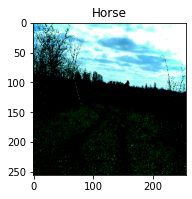

In [8]:
image = preprocess_image_train(next(iter(train_horses))[0], next(iter(train_horses))[1])
plt.subplot(121)
plt.title('Horse')
plt.imshow(image)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_horses = train_horses.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = train_zebras.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Pix2Pix

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
from absl import app
from absl import flags

import tensorflow as tf

FLAGS = flags.FLAGS

flags.DEFINE_integer('buffer_size', 400, 'Shuffle buffer size')
flags.DEFINE_integer('batch_size', 1, 'Batch Size')
flags.DEFINE_integer('epochs', 1, 'Number of epochs')
flags.DEFINE_string('path', None, 'Path to the data folder')
flags.DEFINE_boolean('enable_function', True, 'Enable Function?')

IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


def get_checkpoint_prefix():
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

  return checkpoint_prefix


class Pix2pix(object):
  """Pix2pix class.
  Args:
    epochs: Number of epochs.
    enable_function: If true, train step is decorated with tf.function.
    buffer_size: Shuffle buffer size..
    batch_size: Batch size.
  """

  def __init__(self, epochs, enable_function):
    self.epochs = epochs
    self.enable_function = enable_function
    self.lambda_value = 100
    self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.generator = unet_generator(output_channels=3)
    self.discriminator = discriminator()
    self.checkpoint = tf.train.Checkpoint(
        generator_optimizer=self.generator_optimizer,
        discriminator_optimizer=self.discriminator_optimizer,
        generator=self.generator,
        discriminator=self.discriminator)

  def discriminator_loss(self, disc_real_output, disc_generated_output):
    real_loss = self.loss_object(
        tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = self.loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

  def generator_loss(self, disc_generated_output, gen_output, target):
    gan_loss = self.loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (self.lambda_value * l1_loss)
    return total_gen_loss

  def train_step(self, input_image, target_image):
    """One train step over the generator and discriminator model.
    Args:
      input_image: Input Image.
      target_image: Target image.
    Returns:
      generator loss, discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = self.generator(input_image, training=True)

      disc_real_output = self.discriminator(
          [input_image, target_image], training=True)
      disc_generated_output = self.discriminator(
          [input_image, gen_output], training=True)

      gen_loss = self.generator_loss(
          disc_generated_output, gen_output, target_image)
      disc_loss = self.discriminator_loss(
          disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_loss, self.generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(
        generator_gradients, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(
        discriminator_gradients, self.discriminator.trainable_variables))

    return gen_loss, disc_loss

  def train(self, dataset, checkpoint_pr):
    """Train the GAN for x number of epochs.
    Args:
      dataset: train dataset.
      checkpoint_pr: prefix in which the checkpoints are stored.
    Returns:
      Time for each epoch.
    """
    time_list = []
    if self.enable_function:
      self.train_step = tf.function(self.train_step)

    for epoch in range(self.epochs):
      start_time = time.time()
      for input_image, target_image in dataset:
        gen_loss, disc_loss = self.train_step(input_image, target_image)

      wall_time_sec = time.time() - start_time
      time_list.append(wall_time_sec)

      # saving (checkpoint) the model every 20 epochs
      if (epoch + 1) % 20 == 0:
        self.checkpoint.save(file_prefix=checkpoint_pr)

      template = 'Epoch {}, Generator loss {}, Discriminator Loss {}'
      print (template.format(epoch, gen_loss, disc_loss))

    return time_list


def run_main(argv):
  del argv
  kwargs = {'epochs': FLAGS.epochs, 'enable_function': FLAGS.enable_function,
            'path': FLAGS.path, 'buffer_size': FLAGS.buffer_size,
            'batch_size': FLAGS.batch_size}
  main(**kwargs)


def main(epochs, enable_function, path, buffer_size, batch_size):
  path_to_folder = path

  pix2pix_object = Pix2pix(epochs, enable_function)

  train_dataset, _ = create_dataset(
      os.path.join(path_to_folder, 'train/*.jpg'),
      os.path.join(path_to_folder, 'test/*.jpg'),
      buffer_size, batch_size)
  checkpoint_pr = get_checkpoint_prefix()
  print ('Training ...')
  return pix2pix_object.train(train_dataset, checkpoint_pr)

In [12]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [14]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

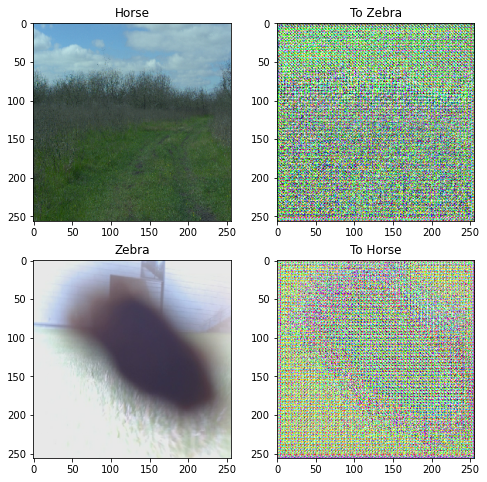

In [15]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

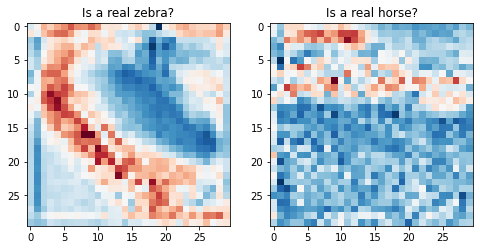

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

# loss function

In [17]:
LAMBDA = 10

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# Training

In [26]:
EPOCHS = 200

In [27]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [28]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [30]:
from IPython.display import clear_output


In [31]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

.............................................................................................................................................................................................................................................................................................................................................................................................................................